In [8]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt


In [9]:
from common import get_full_data
def heart_failure():
    df = pd.read_csv("dataset/heart_failure_clinical_records_dataset.csv")
    # get dependent and independent features
    X=df.iloc[:,:-1]
    y=df.iloc[:,-1]
    return get_full_data(X,y)

In [10]:
from xgboost import XGBRegressor,  XGBClassifier
X,y = heart_failure()
y_classes = [str(t) for t in np.unique(y)]

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBClassifier(device='cpu')

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=500,
    cv=5,
    random_state=state,
    n_jobs=-1,
)
search.fit(X,y)
special_model=search.best_estimator_

In [12]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from common import cross_val_classification_report

special_model.device='cpu'
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X.to_numpy(),
    y=y,
    cv=cv,
    target_names=y_classes
)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       609
           1       0.85      0.47      0.61       288

    accuracy                           0.80       897
   macro avg       0.82      0.72      0.74       897
weighted avg       0.81      0.80      0.79       897



evaluate score  0.1507048309991362


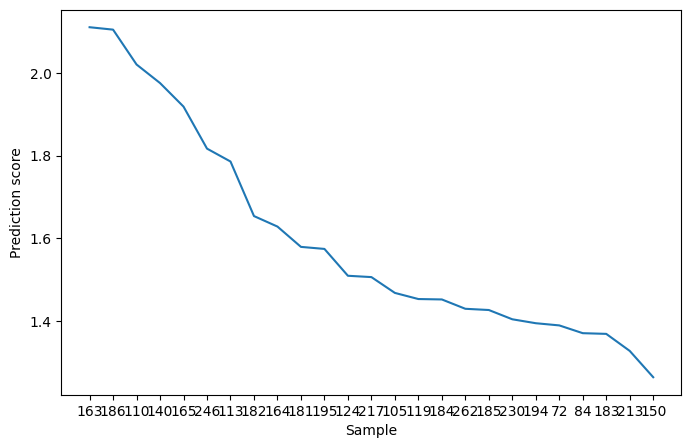

evaluate score  0.1271193497166384


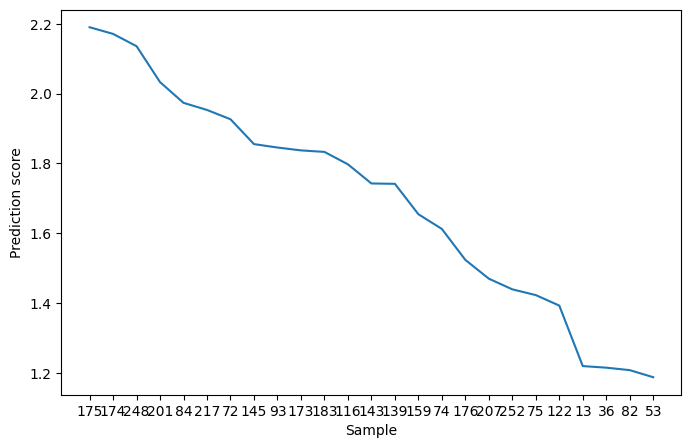

evaluate score  0.12144235219752282


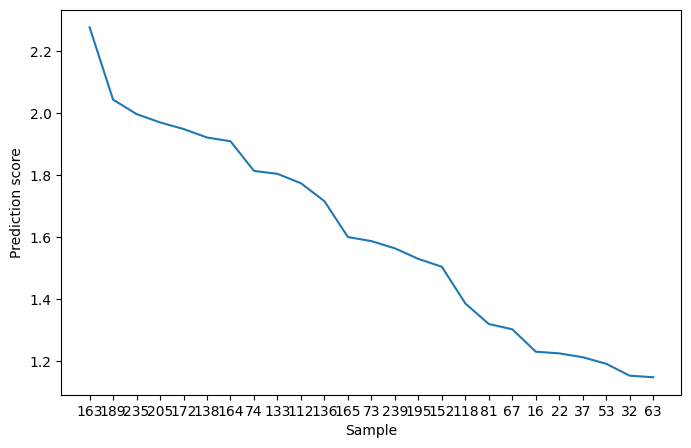

evaluate score  0.1277036315053939
evaluate score  0.1386760937301049
total removed  25
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       582
           1       0.86      0.44      0.59       243

    accuracy                           0.82       825
   macro avg       0.84      0.71      0.73       825
weighted avg       0.82      0.82      0.79       825



In [13]:
# New method
from common import find_outliers, negate

outliers, score = find_outliers(
    X.to_numpy(),
    y,
    special_model,
    outlier_remove_partition=0.05,
    evaluate_loss=metrics.mean_squared_error,
    pred_scoring=metrics.mean_squared_error,
    repeats=5,
    cv=10,
    plot=True
)

X_clean = np.array([x for i,x in enumerate(X.to_numpy()) if i not in outliers])
y_clean = np.array([y_ for i,y_ in enumerate(y) if i not in outliers])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=50)
report = cross_val_classification_report(
    model=special_model,
    X=X_clean,
    y=y_clean,
    cv=cv,
    target_names=y_classes
)
print(report)